In [41]:
# Initialize Otter
import otter
grader = otter.Notebook("hw3.ipynb")

# CPSC 330 - Applied Machine Learning 

## Homework 3: Preprocessing 
### Associated lectures: [Lectures 4, 5, 6](https://github.com/UBC-CS/cpsc330-2023s/tree/main/lectures) 

**Due date: See the [Calendar](https://htmlpreview.github.io/?https://github.com/UBC-CS/cpsc330-2023s/blob/master/docs/calendar.html).**

## Imports 

In [42]:
from hashlib import sha1
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## Instructions
<hr>
rubric={points:6}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2023s/blob/main/docs/homework_instructions.md). 

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

## Introduction <a name="in"></a>
<hr>

A crucial step when using machine learning algorithms on real-world datasets is preprocessing. This homework will give you some practice of data preprocessing and building a supervised machine learning pipeline on a real-world dataset. 

<br><br>

## Exercise 1: Introducing the dataset
<hr>

In this lab, you will be working on [the adult census dataset](https://www.kaggle.com/uciml/adult-census-income#). Download the CSV and save it as `adult.csv` under the data folder in this homework folder. 

This is a classification dataset and the classification task is to predict whether income exceeds 50K per year or not based on the census data. You can find more information on the dataset and features [here](http://archive.ics.uci.edu/ml/datasets/Adult).

The starter code below loads the data CSV (assuming that it is saved as `adult.csv` under the data folder). 

_Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary._

In [43]:
census_df = pd.read_csv("data/adult.csv")
census_df.shape

(32561, 15)

<br><br>

### 1.1 Data splitting 
rubric={autograde:2}

In order to avoid violation of the golden rule, the first step before we do anything is splitting the data. 

**Your tasks:**

1. Split the data into `train_df` (40%) and `test_df` (60%) with `random_state = 123`. Keep the target column (`income`) in the splits so that we can use it in the exploratory data analysis.  

_Usually having more data for training is a good idea. But here I'm using 40%/60% split because running cross-validation with this dataset can take a while on a modest laptop. A smaller training data means it won't take too long to train the model on your laptop. A side advantage of this would be that with a bigger test split, we'll have a more reliable estimate of the model performance!_

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 2

In [44]:
# split code taken from hw2 question 1.2 description. 
train_df, test_df = train_test_split(census_df, test_size=0.6, random_state=123)

In [45]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<br><br>

## Exercise 2: Exploratory data analysis (EDA) <a name="2"></a> 
<hr>

Let's examine our `train_df`. 

In [46]:
train_df.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


We see some missing values represented with a "?". Probably these were the questions not answered by some people during the census.  Usually `.describe()` or `.info()` methods would give you information on missing values. But here, they won't pick "?" as missing values because they are encoded as strings instead of an actual NaN in Python. So let's replace them with `np.nan` before we carry out EDA. If you do not do it, you'll encounter an error later on when you try to pass this data to a classifier. 

In [47]:
train_df = train_df.replace("?", np.nan)
test_df = test_df.replace("?", np.nan)
train_df.shape


(13024, 15)

In [48]:
train_df.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


The "?" symbols are now replaced with NaN values. 

<br><br>

### 2.1 `describe()` method
rubric={autograde:5}

**Your tasks:**

1. Examine the output of `train_df.describe()` with `include='all'` argument and store it in a variable called `census_summary`.
2. What is the highest hours per week someone reported? Store it in a variable called `max_hours_per_week`.
3. What is the most frequently occurring occupation in this dataset? Store it in a variable called `most_freq_occupation`.
4. Store the column names of the columns with missing values as a list in a variable called `missing_vals_cols`. 
5. Store the column names of all numeric-looking columns as a list in a variable called `numeric_cols`.  

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 5

In [49]:
census_summary = train_df.describe(include='all')
print(census_summary)

                 age workclass        fnlwgt education  education.num  \
count   13024.000000     12284  1.302400e+04     13024   13024.000000   
unique           NaN         8           NaN        16            NaN   
top              NaN   Private           NaN   HS-grad            NaN   
freq             NaN      9123           NaN      4153            NaN   
mean       38.546913       NaN  1.884759e+05       NaN      10.057432   
std        13.610225       NaN  1.040895e+05       NaN       2.553084   
min        17.000000       NaN  1.376900e+04       NaN       1.000000   
25%        28.000000       NaN  1.170962e+05       NaN       9.000000   
50%        37.000000       NaN  1.778990e+05       NaN      10.000000   
75%        48.000000       NaN  2.365655e+05       NaN      12.000000   
max        90.000000       NaN  1.184622e+06       NaN      16.000000   

            marital.status      occupation relationship   race    sex  \
count                13024           12281        

In [50]:
max_hours_per_week = census_summary["hours.per.week"].loc["max"]
print(f"The highest hours worked per week reported is {max_hours_per_week}")

The highest hours worked per week reported is 99.0


In [51]:
most_freq_occupation = census_summary["occupation"].loc["top"]
print(f"The most frequent occupation is {most_freq_occupation}")

The most frequent occupation is Prof-specialty


In [52]:
#dtype.kind in 'iufc' taken from: https://www.skytowner.com/explore/checking_if_column_is_numeric_in_pandas_dataframe
missingCols = []
numCols = []
for feature in census_summary:
    if census_summary[feature].loc["count"] != train_df.shape[0]:
        missingCols.append(feature)
    if census_summary[feature].dtype.kind in 'iufc':
        numCols.append(feature)
missing_vals_cols = missingCols
print(missing_vals_cols)
numeric_cols = numCols
print(numeric_cols)

['workclass', 'occupation', 'native.country']
['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']


In [53]:
# Sorting the lists for the autograder
missing_vals_cols.sort()
numeric_cols.sort()

In [54]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 Visualizing features
rubric={points:5}

**Your tasks:**

1. Visualize the histograms of numeric features.  
2. From the visualizations, which features seem relevant for the given prediction task?

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 5

Based only on the shapes of the histograms, the age, education.num, hours.per.week and 
fnlwgt are useful for prediction because they are features with wide ranges of values.
The capital gain and loss visualizations on the otherhand only provide 1 value that occurs frequently,
which means our model will only grow in one direction in that dimension.



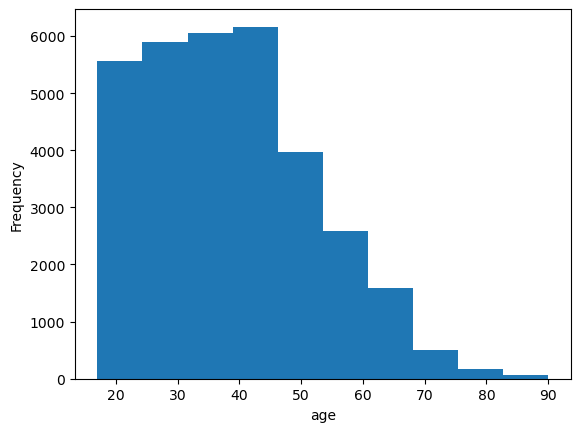

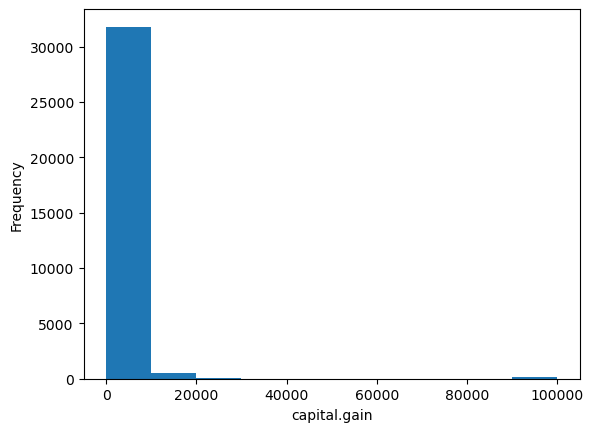

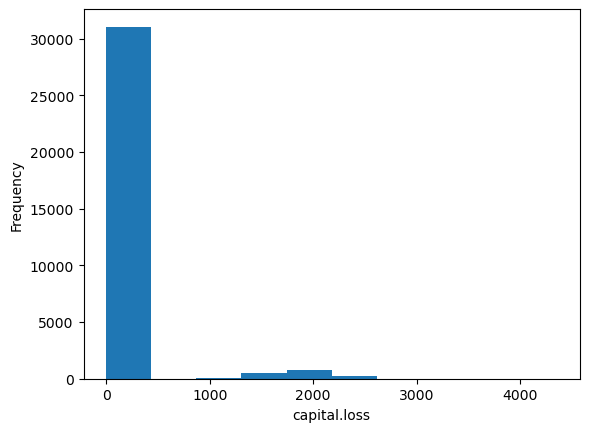

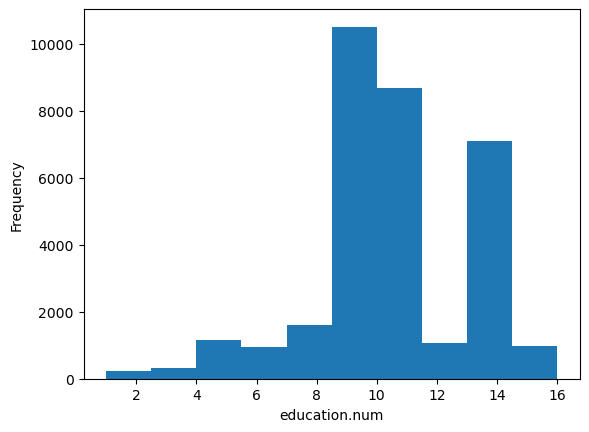

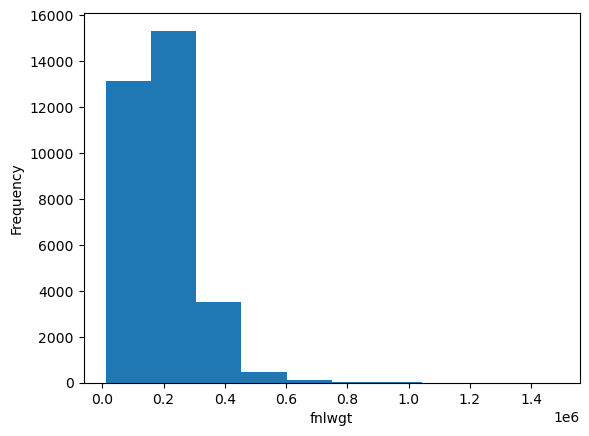

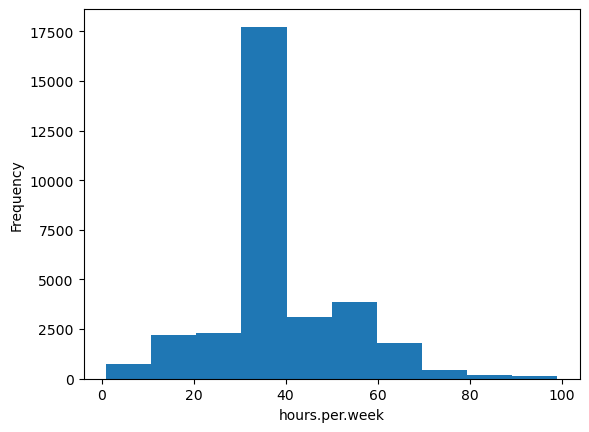

In [55]:
print("""Based only on the shapes of the histograms, the age, education.num, hours.per.week and 
fnlwgt are useful for prediction because they are features with wide ranges of values.
The capital gain and loss visualizations on the otherhand only provide 1 value that occurs frequently,
which means our model will only grow in one direction in that dimension.
""")
for col in numeric_cols:
    plt.hist(census_df[col])
    plt.ylabel("Frequency")
    plt.xlabel(col)
    plt.show()


    

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.3 Identify transformations to apply
rubric={points:13}

Before passing this data to a machine learning model, we need to apply some transformations on different features. Below we are providing possible transformations which can be applied on each column in `census_df`.  

**Your tasks:**
1. Write your justification or explanation for each row in the explanation column. An example explanation is given for the age column. 

> Note: This question is a bit open-ended. If you do not agree with the provided transformation, feel free to argue your case in the explanation. That said, in this assignment, go with the transformations provided below. 

<div class="alert alert-warning">

Solution_2.3
    
</div>

| Feature | Transformation | Explanation
| --- | ----------- | ----- |
| age | scaling |  A numeric feature with no missing values. Good idea to apply scaling, as the range of values (17 to 90) is quite different compared to other numeric features.|
| workclass | imputation, one-hot encoding |A string value being one of 9 possible values, with some NaNs. Imputation will substitute in a value for the NaNs and one hot encoding will turn the workclass values into numeric values that the model can use. We choose one hot encoding over ordinal encoding because we aren't weighing one workclass higher than another |
| fnlwgt | drop |  |
| education | ordinal encoding |We have 16 string classifications for education. The classifications of educations here can be organized where a higher number represents a higher level of education. Ordinal encoding allows us to do just that. |
| education.num | drop |We already have the education feature that we will be applying ordinal encoding to, so this feature is no longer needed|
| marital.status | one-hot encoding  |Marital status is a string value that can be 1 of 7 strings. We need to convert these strings to a numeric value that the model can understand. We choose one-hot encoding over ordinal encoding because we are not weighing one marital status as being greater than another.|
| occupation | imputation, one-hot encoding  |As discovered earlier, occupation has some NaN values in its rows, which will be handled with imputation. The occupation column is also 1 of 15 possible string values, which will be encoded to a numeric value with one-hot encoding rather than ordinal encoding as one occupation should not be favored over another. |
| relationship | one-hot encoding  |The relationship column has string values that can be 1 of 15 possible strings. Using one-hot encoding will convert these strings to a numerical value that our model will be able to use. We use one-hot encoding over ordinal encoding because we do not want to value one relationship over another|
| race | drop  |We choose to drop race because it can be ethically dangerous to keep in our model. By removing race we are removing the possibility for discrimination and promoting fairness and equality.  |
| sex | one-hot encoding with "binary=True" |For the purposes of our data, we are considering there to be only 2 categories of sex. Sex is recorded in the column as strings, so they need to be encoded to a numeric value. We use one-hot encoding with binary=true because we do not want to value one sex over the other, and by setting binary="True" we can represent both male and female with just 1 column |
| capital.gain | scaling | Capital gain is a numeric value, so to prevent our model from unfairly favoring values from one column over another, we need to scale each column so they are comparable. | 
| capital.loss | scaling | Capital loss is a numeric value, so to prevent our model from unfairly favoring values from one column over another, we need to scale each column so they are comparable. |
| hours.per.week | scaling | Hours per week is a numeric value, so to prevent our model from unfairly favoring values from one column over another, we need to scale each column so they are comparable. |
| native.country | imputation, one-hot encoding |Each row in the native country column is populated by 1 of 42 strings. We need to encode these strings into a numeric value that our model can understand. We choose one-hot encoding over ordinal encoding because we do not want to favor one country over another. | 


_Points:_ 13

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<br><br>

### 2.4 Identify feature types 
rubric={autograde:5}


**Your tasks:**
1. Based on the types of transformations you want to apply on the features, identify different feature types and store them in the variables below as lists.  

<div class="alert alert-warning">
    
Solution_2.4
    
</div>

_Points:_ 5

In [56]:
# Fill in the lists below.
numeric_features = ["age", "capital.gain", "capital.loss", "hours.per.week"]
categorical_features = ["workclass", "marital.status", "occupation", "relationship", "native.country" ]
ordinal_features = ["education"]
binary_features = ["sex"]
drop_features = ["fnlwgt", "race", "education.num"]
target = "income"

In [57]:
# Sorting all the lists above for the autograder
numeric_features.sort()
categorical_features.sort()
ordinal_features.sort()
binary_features.sort()
drop_features.sort()

In [58]:
grader.check("q2.4")

q2.4 results: All test cases passed!

<br><br><br><br>

## Exercise 3: Baseline models 

### 3.1 Separating feature vectors and targets  
rubric={autograde:2}

**Your tasks:**

1. Create `X_train`, `y_train`, `X_test`, `y_test` from `train_df` and `test_df`. 

<div class="alert alert-warning">
    
Solution_3.1
    
</div>

_Points:_ 2

In [59]:
X_train = train_df.drop(columns=target)
y_train = train_df[target]
X_test = test_df.drop(columns=target)
y_test = test_df[target]

In [60]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<br><br>

### 3.2 Dummy classifier
rubric={autograde:2}

**Your tasks:**

1. Carry out 5-fold cross-validation using `scikit-learn`'s `cross_validate` function with `return_train_scores=True` and store the results as a dataframe named `dummy_df` where each row corresponds to the results from a cross-validation fold. 

<div class="alert alert-warning">
    
Solution_3.2
    
</div>

_Points:_ 2

In [61]:
dummy = DummyClassifier(strategy="most_frequent")
dummy_df = pd.DataFrame(cross_validate(dummy, X_train, y_train, cv=5, return_train_score=True))
dummy_df

,fit_time,score_time,test_score,train_score
0,0.006980,0.003989,0.758157,0.758230
1,0.004987,0.002992,0.758157,0.758230
2,0.003989,0.003988,0.758157,0.758230
3,0.004953,0.004002,0.758157,0.758230
4,0.004987,0.002992,0.758449,0.758157


In [62]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<br><br>

<!-- BEGIN QUESTION -->

### 3.3 Discussion
rubric={points:2}

**Your tasks:**

1. Hopefully, you were able to run cross-validation with dummy classifier successfully in the question above. At this point, if you train [`sklearn`'s `SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) model on `X_train` and `y_train` would it work? Why or why not? 

<div class="alert alert-warning">
    
Solution_3.3
    
</div>

_Points:_ 2

No, we would not be able to train an SVC model at this time. Currently, our X_train vector has columns that contain data that the SVC model is unable to interpret. Some examples would include NaN cells in the "occupation" column, or the various string objects that have not yet been encoded to numeric values.

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 4: Preprocessing
<hr>

In this dataset, we have different types of features: numeric features, an ordinal feature, categorical features, and a binary feature. We want to apply different transformations on different columns and therefore we need a column transformer. In this exercise, first, we'll define different transformations on different types of features and then will create a `scikit-learn`'s `ColumnTransformer`. For example, the code below creates a `numeric_transformer` for numeric features. 

In [63]:
numeric_transformer = StandardScaler()

In the exercises below, you'll create transformers for other types of features. 

<br><br>

### 4.1 Preprocessing ordinal features
rubric={autograde:5}

**Your tasks:**

1. Create a transformer called `ordinal_transformer` for our ordinal features. 

<div class="alert alert-warning">
    
Solution_4.1
    
</div>

_Points:_ 5

In [64]:
# Code taken from lecture 11 notes
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]
ordinal_transformer=OrdinalEncoder(categories=[education_levels], dtype=int)

In [65]:
grader.check("q4.1")

q4.1 results: All test cases passed!

<br><br>

### 4.2 Preprocessing binary features
rubric={autograde:2}

**Your tasks:**

1. Create a transformer called `binary_transformer` for our binary features.

> _Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary._

<div class="alert alert-warning">
    
Solution_4.2
    
</div>

_Points:_ 2

In [94]:
binary_transformer = OneHotEncoder(drop='if_binary', dtype=int)

In [95]:
grader.check("q4.2")

q4.2 results: All test cases passed!

<br><br>

### 4.3 Preprocessing categorical features
rubric={autograde:4}

In Exercise 2.3, we saw that there are 3 categorical features with missing values. So first we need to impute the missing values and then encode these features with one-hot encoding. For the purpose of this assignment, let's just have imputation as the first step for all categorical features even when they do not have missing values. This should be OK because if a feature doesn't have any missing value,  imputation won't be applied. 

If we want to apply more than one transformation on a set of features, we need to create a [`scikit-learn` `Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). For example, for categorical features we can create a `scikit-learn` `Pipeline` with first step as imputation and the second step as one-hot encoding. 

**Your tasks:**

1. Create a `sklearn` `Pipeline` using [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) called `categorical_transformer` for our categorical features with two steps: `SimpleImputer` for imputation with `strategy="constant"` and `fill_value="missing"` and `OneHotEncoder` with `handle_unknown="ignore"` and `sparse=False` for one-hot encoding. 

<div class="alert alert-warning">
    
Solution_4.3
    
</div>

_Points:_ 4

In [96]:
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False)
)

Ellipsis

In [97]:
grader.check("q4.3")

q4.3 results: All test cases passed!

<br><br>

### 4.4 Creating a column transformer. 
rubric={autograde:7}

**Your tasks:**
1. Create a `sklearn` `ColumnTransformer` named `preprocessor` using [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) with the transformers defined in the previous exercises. Use the sequence below in the column transformer and add a "drop" step for the `drop_features` in the end.  
    - `numeric_transformer`
    - `ordinal_transformer`
    - `binary_transformer`
    - `categorical_transformer`
2. Transform the data by calling `fit_transform` on the training set and save it as a dataframe in a variable called `transformed_df`. How many new columns have been created in the preprocessed data in comparison to the original `X_train`? Store the difference between the number of columns in `transformed_df` and `X_train` in a variable called `n_new_cols`. 

<div class="alert alert-warning">
    
Solution_4.4
    
</div>

_Points:_ 7

In [100]:
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features)
)

In [117]:
transformed_df = preprocessor.fit_transform(train_df)
n_new_cols = transformed_df.shape[1] - X_train.shape[1]

In [118]:
grader.check("q4.4")

q4.4 results: All test cases passed!

<br><br><br><br>

## Exercise 5: Building models 

Now that we have preprocessed features, we are ready to build models. Below, I'm providing the function we used in class which returns mean cross-validation score along with standard deviation for a given model. Use it to keep track of your results. 

In [73]:
results_dict = {}  # dictionary to store all the results

In [119]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

Below I'm showing an example where I call `mean_std_cross_val_scores` with `DummyClassifier`. The function calls `cross_validate` with the passed arguments and returns a series with mean cross-validation results and std of cross-validation. When you train new models, you can just add the results of these models in `results_dict`, which can be easily converted to a dataframe so that you can have a table with all your results. 

In [75]:
# Baseline model

from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(random_state = 123)
pipe = make_pipeline(preprocessor, dummy)
results_dict["dummy"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, cv=5, return_train_score=True
)
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
dummy,0.005 (+/- 0.001),0.004 (+/- 0.001),0.758 (+/- 0.000),0.758 (+/- 0.000)


<br><br>

<!-- BEGIN QUESTION -->

### 5.1 Trying different classifiers
rubric={points:10}

**Your tasks:**

1. For each of the models in the starter code below: 
    - Define a pipeline with two steps: `preprocessor` from 4.4 and the model as your classifier. 
    - Carry out 5-fold cross-validation with the pipeline and get the mean cross-validation scores with std by calling the `mean_std_cross_val_scores` function above. 
    - Store the results in a dataframe called `income_pred_results_df` with the model names in the `models` dictionary below as the index and each row representing results returned by `mean_std_cross_val_scores` function above. In other words, `income_pred_results_df` should look similar to the `results_df` dataframe above with more rows for the models below. 
    
> This might take a while to run. Be patient! 

In [76]:
models = {
    "decision tree": DecisionTreeClassifier(random_state=123),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state=123),
}

<div class="alert alert-warning">
    
Solution_5.1
    
</div>

_Points:_ 10

In [137]:
for m in models:
    pipe = make_pipeline(
        preprocessor, models[m]
    ) 
    results_dict[m] = mean_std_cross_val_scores(pipe, X_train, y_train, return_train_score=True)

pd.DataFrame(results_dict).T

    

,fit_time,score_time,test_score,train_score
dummy,0.005 (+/- 0.001),0.004 (+/- 0.001),0.758 (+/- 0.000),0.758 (+/- 0.000)
decision tree,0.097 (+/- 0.004),0.013 (+/- 0.001),0.814 (+/- 0.012),0.987 (+/- 0.001)
kNN,0.034 (+/- 0.001),0.181 (+/- 0.004),0.836 (+/- 0.008),0.883 (+/- 0.002)
RBF SVM,2.880 (+/- 0.239),1.237 (+/- 0.040),0.852 (+/- 0.005),0.855 (+/- 0.002)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 5.2 Discussion 
rubric={points:5}

**Your tasks:**

1. Examine the train and validation accuracies and `fit` and `score` times for all the models in the results above. How do the validation accuracies compare to the `DummyClassifier` model? Which model has the best validation accuracy? Which model is the fastest one? Which model is overfitting the most and the least?  


<div class="alert alert-warning">
    
Solution_5.2
    
</div>

_Points:_ 5

Compared to the DummyClassifier, all validation accuracies are slightly better than Dummy, in the 0.81-0.85 range.
RBF SVM has the best validation accuracy at 0.852(+/- 0.005)
The fastest was the Dummy. 
After Dummy, if considering only fitting time, KNN is faster.
After Dummy, if considering fit time + score time, Decision tree is faster.
Decision tree had the most overfitting, with train_score of 0.987 and test_score of 0.814 (difference of 0.173)
After Dummy, RBF SVM had the most underfitting, with train_score and test_score of 0.852 and 0.855 respectively._Type your answer here, replacing this text._

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 5.3 Hyperparameter optimization
rubric={points:10}

In this exercise, you'll carry out hyperparameter optimization for the hyperparameter `C` of SVC RBF classifier. In practice, you'll carry out hyperparameter optimization for all different hyperparameters of the most promising classifiers. For the purpose of this assignment, we'll only do it for the `SVC` classifier with one hyperparameter, namely `C`. 

**Your tasks:**

1. For each `C` value in the `param_grid` below: 
    - Create a pipeline object with two steps: preprocessor from 4.4 and `SVC` classifier with the `C` value.
    - Carry out 5-fold cross validation with the pipeline.  
    - Store the results in `results_dict` and display results as a pandas DataFrame. 
2. Which hyperparameter value seems to be performing the best? Store it in a variable called `best_C`. (Since this question is not autograded, please store the value directly as a number, something like `best_C = 0.001`, if `C = 0.001` is giving you the best CV score.) Is it different than the default value for the hyperparameter used by `scikit-learn`? 

> Note: Running this will take a while. Please be patient. 

In [79]:
param_grid = {"C": np.logspace(-1, 2, 4)}
param_grid

{'C': array([  0.1,   1. ,  10. , 100. ])}

<div class="alert alert-warning">
    
Solution_5.3
    
</div>

_Points:_ 10

_Type your answer here, replacing this text._

In [146]:
for c in param_grid['C']:
    pipe = make_pipeline(
        preprocessor, SVC(C=c, random_state=123))
    results_dict[c] = mean_std_cross_val_scores(pipe, X_train, y_train, return_train_score=True)
pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
dummy,0.005 (+/- 0.001),0.004 (+/- 0.001),0.758 (+/- 0.000),0.758 (+/- 0.000)
decision tree,0.097 (+/- 0.004),0.013 (+/- 0.001),0.814 (+/- 0.012),0.987 (+/- 0.001)
kNN,0.034 (+/- 0.001),0.181 (+/- 0.004),0.836 (+/- 0.008),0.883 (+/- 0.002)
RBF SVM,2.880 (+/- 0.239),1.237 (+/- 0.040),0.852 (+/- 0.005),0.855 (+/- 0.002)
0.1,3.259 (+/- 0.153),1.381 (+/- 0.017),0.838 (+/- 0.006),0.838 (+/- 0.002)
1.0,2.705 (+/- 0.065),1.212 (+/- 0.020),0.852 (+/- 0.005),0.855 (+/- 0.002)
10.0,2.777 (+/- 0.164),1.105 (+/- 0.024),0.858 (+/- 0.005),0.862 (+/- 0.002)
100.0,3.719 (+/- 0.144),1.083 (+/- 0.037),0.860 (+/- 0.006),0.871 (+/- 0.002)


In [147]:
best_C = 10.0
print("Yes this is better than the default")

Yes this is better than the default


<!-- END QUESTION -->

<br><br><br><br>

## Exercise 6: Evaluating on the test set 
<hr>

Now that we have a best performing model, it's time to assess our model on the set aside test set. In this exercise, you'll examine whether the results you obtained using cross-validation on the train set are consistent with the results on the test set. 

### 6.1 Scoring on the unseen test set 
rubric={autograde:4}

**Your tasks:**

1. Create a pipeline named `final_pipeline` with the preprocessor from 4.4 as the first step and the best performing SVC model from 5.4 as the second step. 
2. Train the pipeline on the entire training set `X_train` and `y_train`. 
3. Score the pipeline on `X_test` and `y_test` and store the score in a variable called `test_score`.  

<div class="alert alert-warning">
    
Solution_6.1
    
</div>

_Points:_ 4

_Type your answer here, replacing this text._

In [83]:
final_pipeline = None
test_score = None

...

Ellipsis

In [84]:
grader.check("q6.1")

q6.1 results:
    q6.1 - 1 result:
        ❌ Test case failed
        Trying:
            assert not final_pipeline is None, "Are you using the correct variable name?"
        Expecting nothing
        **********************************************************************
        Line 2, in q6.1 0
        Failed example:
            assert not final_pipeline is None, "Are you using the correct variable name?"
        Exception raised:
            Traceback (most recent call last):
              File "C:\Users\Brad\miniconda3\envs\cpsc330\lib\doctest.py", line 1350, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q6.1 0[0]>", line 1, in <module>
                assert not final_pipeline is None, "Are you using the correct variable name?"
            AssertionError: Are you using the correct variable name?
        Trying:
            assert not test_score is None, "Are you using the correct variable name?"
        Expecting nothing
        **********************************************************************
        Line 3, in q6.1 0
        Failed example:
            assert not test_score is None, "Are you using the correct variable name?"
        Exception raised:
            Traceback (most recent call last):
              File "C:\Users\Brad\miniconda3\envs\cpsc330\lib\doctest.py", line 1350, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q6.1 0[1]>", line 1, in <module>
                assert not test_score is None, "Are you using the correct variable name?"
            AssertionError: Are you using the correct variable name?
        Trying:
            assert len(final_pipeline.named_steps) == 2, "The final pipeline needs to have two steps: one for the preprocessor and one for SVC."
        Expecting nothing
        **********************************************************************
        Line 4, in q6.1 0
        Failed example:
            assert len(final_pipeline.named_steps) == 2, "The final pipeline needs to have two steps: one for the preprocessor and one for SVC."
        Exception raised:
            Traceback (most recent call last):
              File "C:\Users\Brad\miniconda3\envs\cpsc330\lib\doctest.py", line 1350, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q6.1 0[2]>", line 1, in <module>
                assert len(final_pipeline.named_steps) == 2, "The final pipeline needs to have two steps: one for the preprocessor and one for SVC."
            AttributeError: 'NoneType' object has no attribute 'named_steps'
        Trying:
            assert final_pipeline.n_features_in_ == 14, "Make sure to pass the original X_train to fit"
        Expecting nothing
        **********************************************************************
        Line 5, in q6.1 0
        Failed example:
            assert final_pipeline.n_features_in_ == 14, "Make sure to pass the original X_train to fit"
        Exception raised:
            Traceback (most recent call last):
              File "C:\Users\Brad\miniconda3\envs\cpsc330\lib\doctest.py", line 1350, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q6.1 0[3]>", line 1, in <module>
                assert final_pipeline.n_features_in_ == 14, "Make sure to pass the original X_train to fit"
            AttributeError: 'NoneType' object has no attribute 'n_features_in_'
        Trying:
            assert final_pipeline.named_steps['svc'].get_params()['C'] == best_C, "Are you using the best C value from the previous exercise?"
        Expecting nothing
        **********************************************************************
        Line 6, in q6.1 0
        Failed example:
            assert final_pipeline.named_steps['svc'].get_params()['C'] == best_C, "Are you using the best C value from the previous exercise?"
        Exception raised:
     

<br><br><br><br>

## Exercise 7: Short answer questions

<!-- BEGIN QUESTION -->

### 7.1 kNNs toy example
rubric={points:3}

Suppose you want to get predictions using the $k$-nearest neighbour algorithm on the toy dataset below. 

$$ X = \begin{bmatrix}5 & 2\\4 & -2\\  2 & 2\\ 10 & 10\\ 9 & -1\\ 9& 9\end{bmatrix}, \quad y = \begin{bmatrix}0\\0\\1\\1\\1\\2\end{bmatrix}.$$

Suppose you are given a new data point $x=\begin{bmatrix} 0\\0\end{bmatrix}$.  

1. What would the model predict when $k=1$?
2. What would the model predict when $k=3$?
3. What would the model predict when $k=3$ if we were doing regression rather than classification? 

_Points:_ 3

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 7.2 Preprocessing
rubric={points:8}

1. What is the problem with calling `fit_transform` on your test data with `StandardScaler`?
2. Why is it important to follow the Golden Rule? If you violate it, will that give you a worse classifier?
3. What are two advantages of using sklearn Pipelines? 
4. When is it appropriate to use sklearn `ColumnTransformer`? 

_Points:_ 8

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 

Congratulations on finishing the homework! This was a tricky one but I hope you are feeling good after working on it. You are now ready to build a simple supervised machine learning pipeline on real-world datasets! Well done :clap:! 

![](img/eva-well-done.png)

